# Game Verifier

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: 
    !pip install -Uqq fastai

In [2]:
import shutil

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
from torch import nn

## Gathering Data

In [ ]:
import requests
from dotenv import load_dotenv

load_dotenv()

USERNAME = os.getenv('REDDIT_USERNAME')
PASSWORD = os.getenv('REDDIT_PASSWORD')
APP_ID = os.getenv('APP_ID')
APP_NAME = os.getenv('APP_NAME')
APP_SECRET = os.getenv('APP_SECRET')

In [ ]:
import re

def is_valid_gallery_url(url): 
    return isinstance(url, str) and re.match(r'https?://www.reddit.com/gallery/[a-z0-9]+', url)

def get_gallery_id(url): 
    return url.split('/')[-1]

In [ ]:
# Official Reddit API, requires auth
REDDIT_PUB_URL = 'https://www.reddit.com/'
REDDIT_OUTH_URL = 'https://oauth.reddit.com/'


def get_api_token():
    data = {'grant_type': 'password',
            'username': USERNAME, 'password': PASSWORD}
    auth = requests.auth.HTTPBasicAuth(APP_ID, APP_SECRET)
    r = requests.post(REDDIT_PUB_URL + 'api/v1/access_token',
                      headers={'user-agent': f'{APP_NAME} by {USERNAME}'},
                      data=data, auth=auth)
    d = r.json()
    return 'bearer ' + d['access_token']


def get_posts_reddit(subreddit, token, **params):
    headers = {'Authorization': token,
               'User-Agent': f'{APP_NAME} by {USERNAME}'}
    response = requests.get(
        REDDIT_OUTH_URL + f'r/{subreddit}/new.json', headers=headers, params=params)
    if response.status_code == 200:
        return response.json()['data']
    else:
        raise Exception(f'Request failed with status code {response.status_code}')


def get_gallery_urls_reddit(subreddit, token, classes, limits=100, max_imgs=1000):
    urls = [[] for _ in classes]
    limits = list(limits) if hasattr(
        limits, '__iter__') else [limits] * len(classes)
    next_name = ''
    while np.any([len(u) < l for u, l in zip(urls, limits)]):
        posts = get_posts_reddit(subreddit, token, limit=100, after=next_name)
        next_name = posts['after']
        for post in posts['children']:
            post = post['data']
            label, url = post['link_flair_text'], post['url']
            is_valid = is_valid_gallery_url(url)
            gallery_data = post['gallery_data'] if 'gallery_data' in post else None
            img_cnt = len(gallery_data['items']) if gallery_data else 0
            if label in classes and is_valid and img_cnt <= max_imgs:
                index = classes.index(label)
                if len(urls[index]) < limits[index]:
                    urls[index].append(url)
    return urls

In [ ]:
# Thrid-party PullPush API, no auth
PULLPUSH_URL = "https://api.pullpush.io/reddit/search/submission/"


def get_posts_pullpush(subreddit, **kwargs):
    params = {'subreddit': subreddit, **kwargs}
    response = requests.get(PULLPUSH_URL, params=params)
    return response.json()


def get_gallery_urls_pullpush(subreddit, classes, limits=100, max_imgs=1000):
    urls = [[] for _ in classes]
    limits = list(limits) if hasattr(
        limits, '__iter__') else [limits] * len(classes)
    cur_time = int(time.time())
    while np.any([len(u) < l for u, l in zip(urls, limits)]):
        posts = get_posts_pullpush(
            subreddit, locked=True, size=100, before=cur_time)
        if 'data' not in posts or not len(posts['data']):
            break
        for post in posts['data']:
            cur_time = int(post['created_utc'])
            label, url = post['link_flair_text'], post['url']
            is_valid = is_valid_gallery_url(url)
            gallery_data = post['gallery_data'] if 'gallery_data' in post else None
            img_cnt = len(gallery_data['items']) if gallery_data else 0
            if label in classes and is_valid and img_cnt <= max_imgs:
                index = classes.index(label)
                if len(urls[index]) < limits[index]:
                    urls[index].append(url)
    return urls

In [ ]:
token = get_api_token()
token

In [3]:
SUBREDDIT = "gameverifying"
CLASSES = ['Legitimate', 'Fake']
LIMIT, MAX_IMAGES = 150, 2

In [ ]:
# Using Official Reddit API
urls = get_gallery_urls_reddit(SUBREDDIT, token, CLASSES, LIMIT, MAX_IMAGES)

In [ ]:
# Using Third-party Pullpush API
urls = get_gallery_urls_pullpush(SUBREDDIT, CLASSES, LIMIT, MAX_IMAGES)

In [ ]:
for cls, links in zip(CLASSES, urls):
    print(f'{cls}: {len(set(links))}')

In [ ]:
import subprocess

def download_gallery_images(path, url):
    path = Path(path)
    id = get_gallery_id(url)
    dirname = path / id
    dirname.mkdir(exist_ok=True, parents=True)
    commands = ['gallery-dl', url, '-D', dirname]
    subprocess.run(commands, stdout=subprocess.DEVNULL,
                   stderr=subprocess.DEVNULL)

In [4]:
INPUT_DIR = Path('/kaggle/input' if iskaggle else '.')
OUTPUT_DIR = Path('/kaggle/working' if iskaggle else '.')

ROOT_DIR = INPUT_DIR / 'game-verifier-data' if iskaggle else INPUT_DIR
DATA_DIR = ROOT_DIR / 'images'

In [ ]:
shutil.rmtree(DATA_DIR, ignore_errors=True)
for cls, links in zip(CLASSES, urls): 
    path = DATA_DIR / cls.lower()
    parallel(partial(download_gallery_images, path), set(links), progress=True)

In [ ]:
fnames = get_image_files(DATA_DIR)
failed = verify_images(fnames)
failed.map(Path.unlink)
len(failed)

## Cleaning Data 

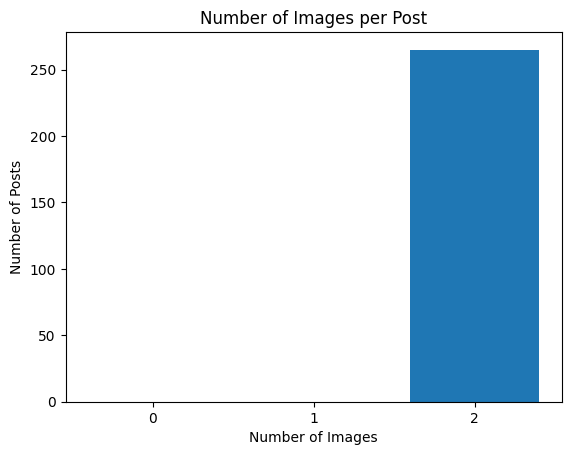

In [7]:
from collections import Counter
from operator import itemgetter

def get_gallery_dirs(root): 
    return np.concatenate([(root / cls.lower()).ls() for cls in CLASSES])

gal_dirs = get_gallery_dirs(DATA_DIR)
img_cnts = {d : len(get_image_files(d)) for d in gal_dirs}

max_cnt = max(img_cnts.values())
counter = Counter(img_cnts.values())

labels = list(range(max_cnt + 1))
freqs = list(map(counter.__getitem__, labels))

plt.bar(labels, freqs)

plt.title("Number of Images per Post")
plt.xlabel("Number of Images")
plt.ylabel("Number of Posts")
plt.xticks(labels)

plt.show()

In [ ]:
top_cnts = sorted(img_cnts.items(), key=itemgetter(1), reverse=True)

for dirname, cnt in top_cnts[:10]: 
    print(f'{str(dirname).ljust(25)}\t{cnt}') 

In [ ]:
@delegates(ImagesCleaner)
class GalleryCleaner(GetAttr):
    def __init__(self, dirnames, **kwargs):
        self.default = self.iw = ImagesCleaner(**kwargs)
        self.dd_dnames = widgets.Dropdown(options=dirnames)
        self.btn_select = widgets.Button(description='Select All')
        self.btn_delete = widgets.Button(description='Delete')
        self.dd_dnames.observe(self.on_change_dir, names='value')
        self.btn_select.on_click(self.on_select_all)
        self.btn_delete.on_click(self.on_delete_all)
        self.on_change_dir()
        self.widget = VBox([self.dd_dnames, self.iw.widget,
                           self.btn_select, self.btn_delete])

    def _ipython_display_(self): display(self.widget)

    def on_change_dir(self, change=None):
        fnames = sorted(get_image_files(self.dd_dnames.value))
        self.iw.set_fns(fnames)

    def on_select_all(self, btn): 
        for dd in L(self.iw.widget.children).itemgot(1): 
            dd.value = '<Delete>'

    def on_delete_all(self, btn): 
        for idx in self.iw.delete(): 
            self.iw.fns[idx].unlink()
        self.on_change_dir()

In [ ]:
cleaner = GalleryCleaner(L(top_cnts).itemgot(0))
cleaner

In [ ]:
failed = list(map(shutil.rmtree, [d for d, c in img_cnts.items() if c == 0]))
len(failed)

In [ ]:
def split_gallery(dirname):
    dirname = Path(dirname)
    fnames = sorted(get_image_files(dirname))
    for i in range(len(fnames) // 2):
        old_parent = fnames[2*i].parent
        new_parent = old_parent.with_name(
            f'{old_parent.name}_{i}') if i > 0 else old_parent
        new_parent.mkdir(exist_ok=True)
        shutil.move(fnames[2*i], new_parent / fnames[2*i].name)
        shutil.move(fnames[2*i+1], new_parent / fnames[2*i+1].name)
    if len(fnames) % 2 == 1:
        fnames[-1].unlink()

split = list(map(split_gallery, get_gallery_dirs(DATA_DIR)))
len(split)

In [ ]:
def rename_gallery_images(dirname):
    dirname = Path(dirname)
    fnames = sorted(get_image_files(dirname))
    for i in range(len(fnames)):
        ext = fnames[i].suffix
        fnames[i].rename(fnames[i].with_name(f'{(i+1):03}{ext}'))

renamed = list(map(rename_gallery_images, get_gallery_dirs(DATA_DIR)))
len(renamed)

In [ ]:
for cls in CLASSES: 
    cnt = len((DATA_DIR / cls.lower()).ls())
    print(f'{cls}: {cnt}')

## Dataloaders

In [5]:
class ImageTuple(fastuple): 
    @classmethod
    def create(cls, dirname, **kwargs): 
        return cls(tuple(PILImage.create(f, **kwargs) for f in sorted(get_image_files(dirname))))

    def show(self, ctx=None, **kwargs):
        t1, t2, *_ = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

def ImageTupleBlock(): 
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

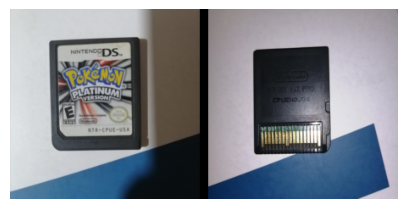

In [12]:
dirname = get_gallery_dirs(DATA_DIR)[0]
img = Resize(224, method=ResizeMethod.Squish)(ImageTuple.create(dirname))
tst = ToTensor()(img)
tst.show();

In [ ]:
dblock = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_gallery_dirs,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(480, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224),
)

@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

dls = dblock.dataloaders(DATA_DIR)
dls.show_batch(max_n=6)

## Learners

In [ ]:
MODEL_DIR = OUTPUT_DIR / 'models'

In [ ]:
class VerifierModel(nn.Module):
    def __init__(self, arch, n_out=1, **kwargs):
        super().__init__()
        model = timm.create_model(arch, pretrained=True, num_classes=0, **kwargs)
        self.encoder = TimmBody(model)
        self.cfg = model.default_cfg
        self.head = create_head(self.encoder.model.num_features * 2, n_out)

    def forward(self, xs):
        x1, x2, *_ = xs
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)


model = VerifierModel('resnet18', n_out=dls.c)
norm_tfms = Normalize.from_stats(model.cfg['mean'], model.cfg['std'])
dls.add_tfms([norm_tfms], 'after_batch')
learn = Learner(dls, model, metrics=error_rate, model_dir=MODEL_DIR)
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
epochs, lr = 4, 1e-3
learn.fine_tune(epochs, base_lr=lr)

In [ ]:
@typedispatch
def show_results(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

learn.show_results(max_n=6)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()